# PyTorch con Huber Loss y LeakyReLU para California Housing


Este notebook mejora el modelo anterior aplicando:
- Pérdida Huber (`SmoothL1Loss`)
- Activación `LeakyReLU`
- Regularización adicional con `weight_decay`


In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from preprocessing import get_preprocessor
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cpu


In [2]:

housing = pd.read_csv("housing.csv")
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"].copy()

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


In [3]:

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).astype(np.float32)
y_valid_scaled = y_scaler.transform(y_valid.values.reshape(-1, 1)).astype(np.float32)
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).astype(np.float32)


In [4]:

preprocessor = get_preprocessor(housing)
X_train_prep = preprocessor.fit_transform(X_train).astype(np.float32)
X_valid_prep = preprocessor.transform(X_valid).astype(np.float32)
X_test_prep = preprocessor.transform(X_test).astype(np.float32)

X_train_tensor = torch.tensor(X_train_prep)
y_train_tensor = torch.tensor(y_train_scaled)
X_valid_tensor = torch.tensor(X_valid_prep).to(device)
y_valid_tensor = torch.tensor(y_valid_scaled).to(device)
X_test_tensor = torch.tensor(X_test_prep).to(device)
y_test_tensor = torch.tensor(y_test_scaled).to(device)


In [5]:

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)


In [6]:

class HousingNet(nn.Module):
    def __init__(self, input_dim):
        super(HousingNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.01),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model = HousingNet(X_train_prep.shape[1]).to(device)


In [7]:

criterion = nn.SmoothL1Loss()  # Huber loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 100
best_rmse = float('inf')
patience = 10
trigger = 0

for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_valid_tensor)
        val_rmse = np.sqrt(mean_squared_error(
            y_scaler.inverse_transform(y_valid_tensor.cpu().numpy()),
            y_scaler.inverse_transform(val_outputs.cpu().numpy())
        ))

    print(f"Epoch {epoch+1}, Val RMSE: {val_rmse:.2f}")
    
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_state = model.state_dict()
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping.")
            break


Epoch 1, Val RMSE: 61598.76
Epoch 2, Val RMSE: 58067.47
Epoch 3, Val RMSE: 57683.98
Epoch 4, Val RMSE: 56956.96
Epoch 5, Val RMSE: 56969.17
Epoch 6, Val RMSE: 56759.08
Epoch 7, Val RMSE: 56582.66
Epoch 8, Val RMSE: 54597.30
Epoch 9, Val RMSE: 54449.17
Epoch 10, Val RMSE: 53842.37
Epoch 11, Val RMSE: 53735.89
Epoch 12, Val RMSE: 54129.96
Epoch 13, Val RMSE: 54375.64
Epoch 14, Val RMSE: 53333.13
Epoch 15, Val RMSE: 53525.60
Epoch 16, Val RMSE: 52233.68
Epoch 17, Val RMSE: 52506.71
Epoch 18, Val RMSE: 52425.71
Epoch 19, Val RMSE: 52630.00
Epoch 20, Val RMSE: 52609.50
Epoch 21, Val RMSE: 52526.88
Epoch 22, Val RMSE: 52491.31
Epoch 23, Val RMSE: 52034.31
Epoch 24, Val RMSE: 52333.80
Epoch 25, Val RMSE: 52577.05
Epoch 26, Val RMSE: 51823.60
Epoch 27, Val RMSE: 53837.37
Epoch 28, Val RMSE: 51698.24
Epoch 29, Val RMSE: 52118.62
Epoch 30, Val RMSE: 51353.11
Epoch 31, Val RMSE: 51000.08
Epoch 32, Val RMSE: 51739.37
Epoch 33, Val RMSE: 52182.44
Epoch 34, Val RMSE: 52079.52
Epoch 35, Val RMSE: 516

✅ RMSE test: 49922.58648147831


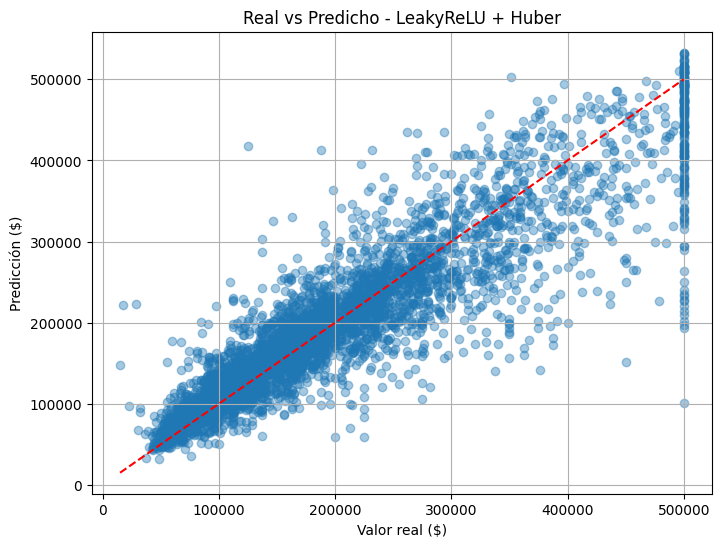

In [8]:

model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    y_test_pred_scaled = model(X_test_tensor).cpu().numpy()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("✅ RMSE test:", rmse_test)

# Gráfico real vs predicho
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor real ($)")
plt.ylabel("Predicción ($)")
plt.title("Real vs Predicho - LeakyReLU + Huber")
plt.grid(True)
plt.show()

# Guardar predicciones
pd.DataFrame({
    "y_real": y_test.values,
    "y_pred": y_test_pred.flatten()
}).to_csv("predicciones_test_pytorch_huber.csv", index=False)
